In [11]:
from __future__ import absolute_import, division, print_function

import sys
import os
import pandas as pd
import numpy as np

#屏蔽warnings
import warnings
warnings.filterwarnings("ignore")

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# 绘图
import matplotlib.pylab as plt
import seaborn as sns
#一些参数风格设置
pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set(style='ticks', context='poster')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


             UMCSENT
DATE                
2000-01-01 112.00000
2000-02-01 111.30000
2000-03-01 107.10000
2000-04-01 109.20000
2000-05-01 110.70000


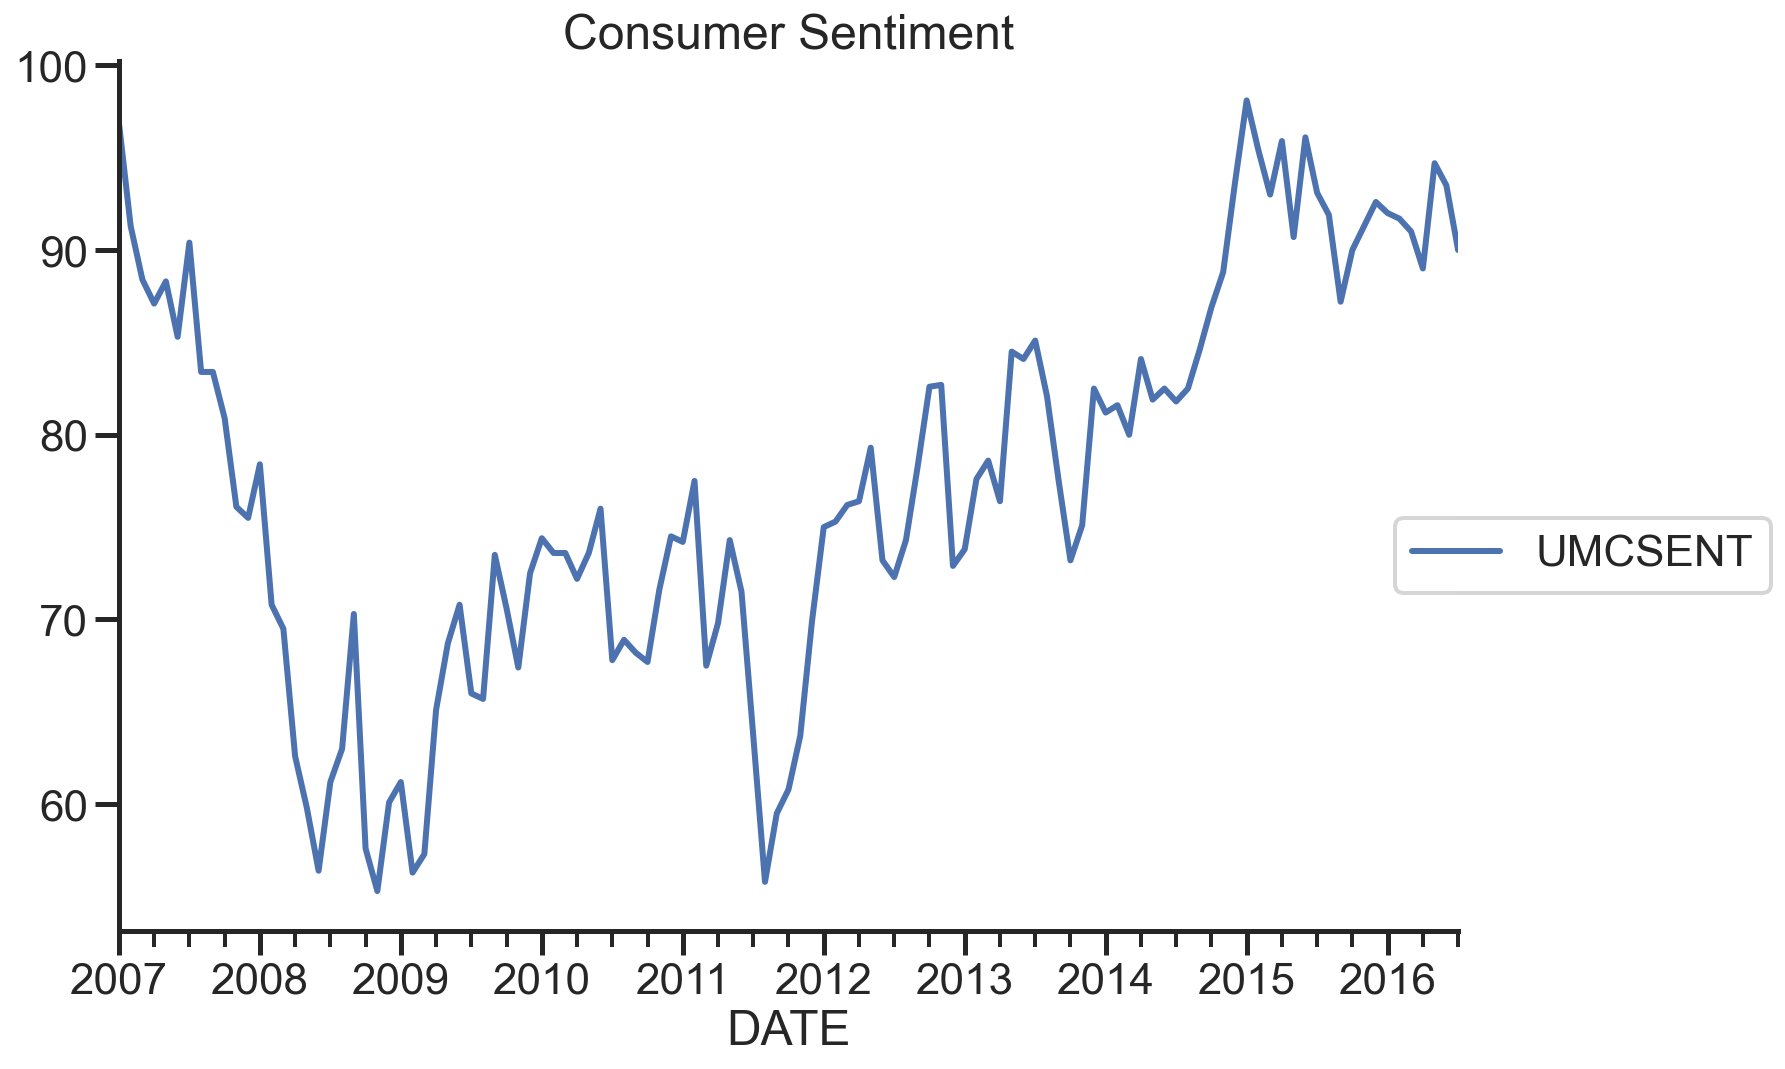

In [12]:
#数据读取
Sentiment = pd.read_csv('sentiment.csv',index_col=0, parse_dates=[0])
print(Sentiment.head())
#切分为测试数据和训练数据
n_sample = Sentiment.shape[0]
n_train = int(0.95 * n_sample)+1
n_forecast = n_sample - n_train
ts_train = Sentiment.iloc[:n_train]['UMCSENT']
ts_test = Sentiment.iloc[:n_forecast]['UMCSENT']
#截取10年数据并展示
sentiment_short = Sentiment.loc['2007':'2017']
sentiment_short.plot(figsize = (12,8))
plt.title("Consumer Sentiment")
plt.legend(bbox_to_anchor = (1.25,0.5))
sns.despine()
plt.show()

            UMCSENT   diff_1  diff_2
DATE                                
2007-01-01 96.90000      NaN     NaN
2007-02-01 91.30000 -5.60000     NaN
2007-03-01 88.40000 -2.90000 2.70000
2007-04-01 87.10000 -1.30000 1.60000
2007-05-01 88.30000  1.20000 2.50000


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

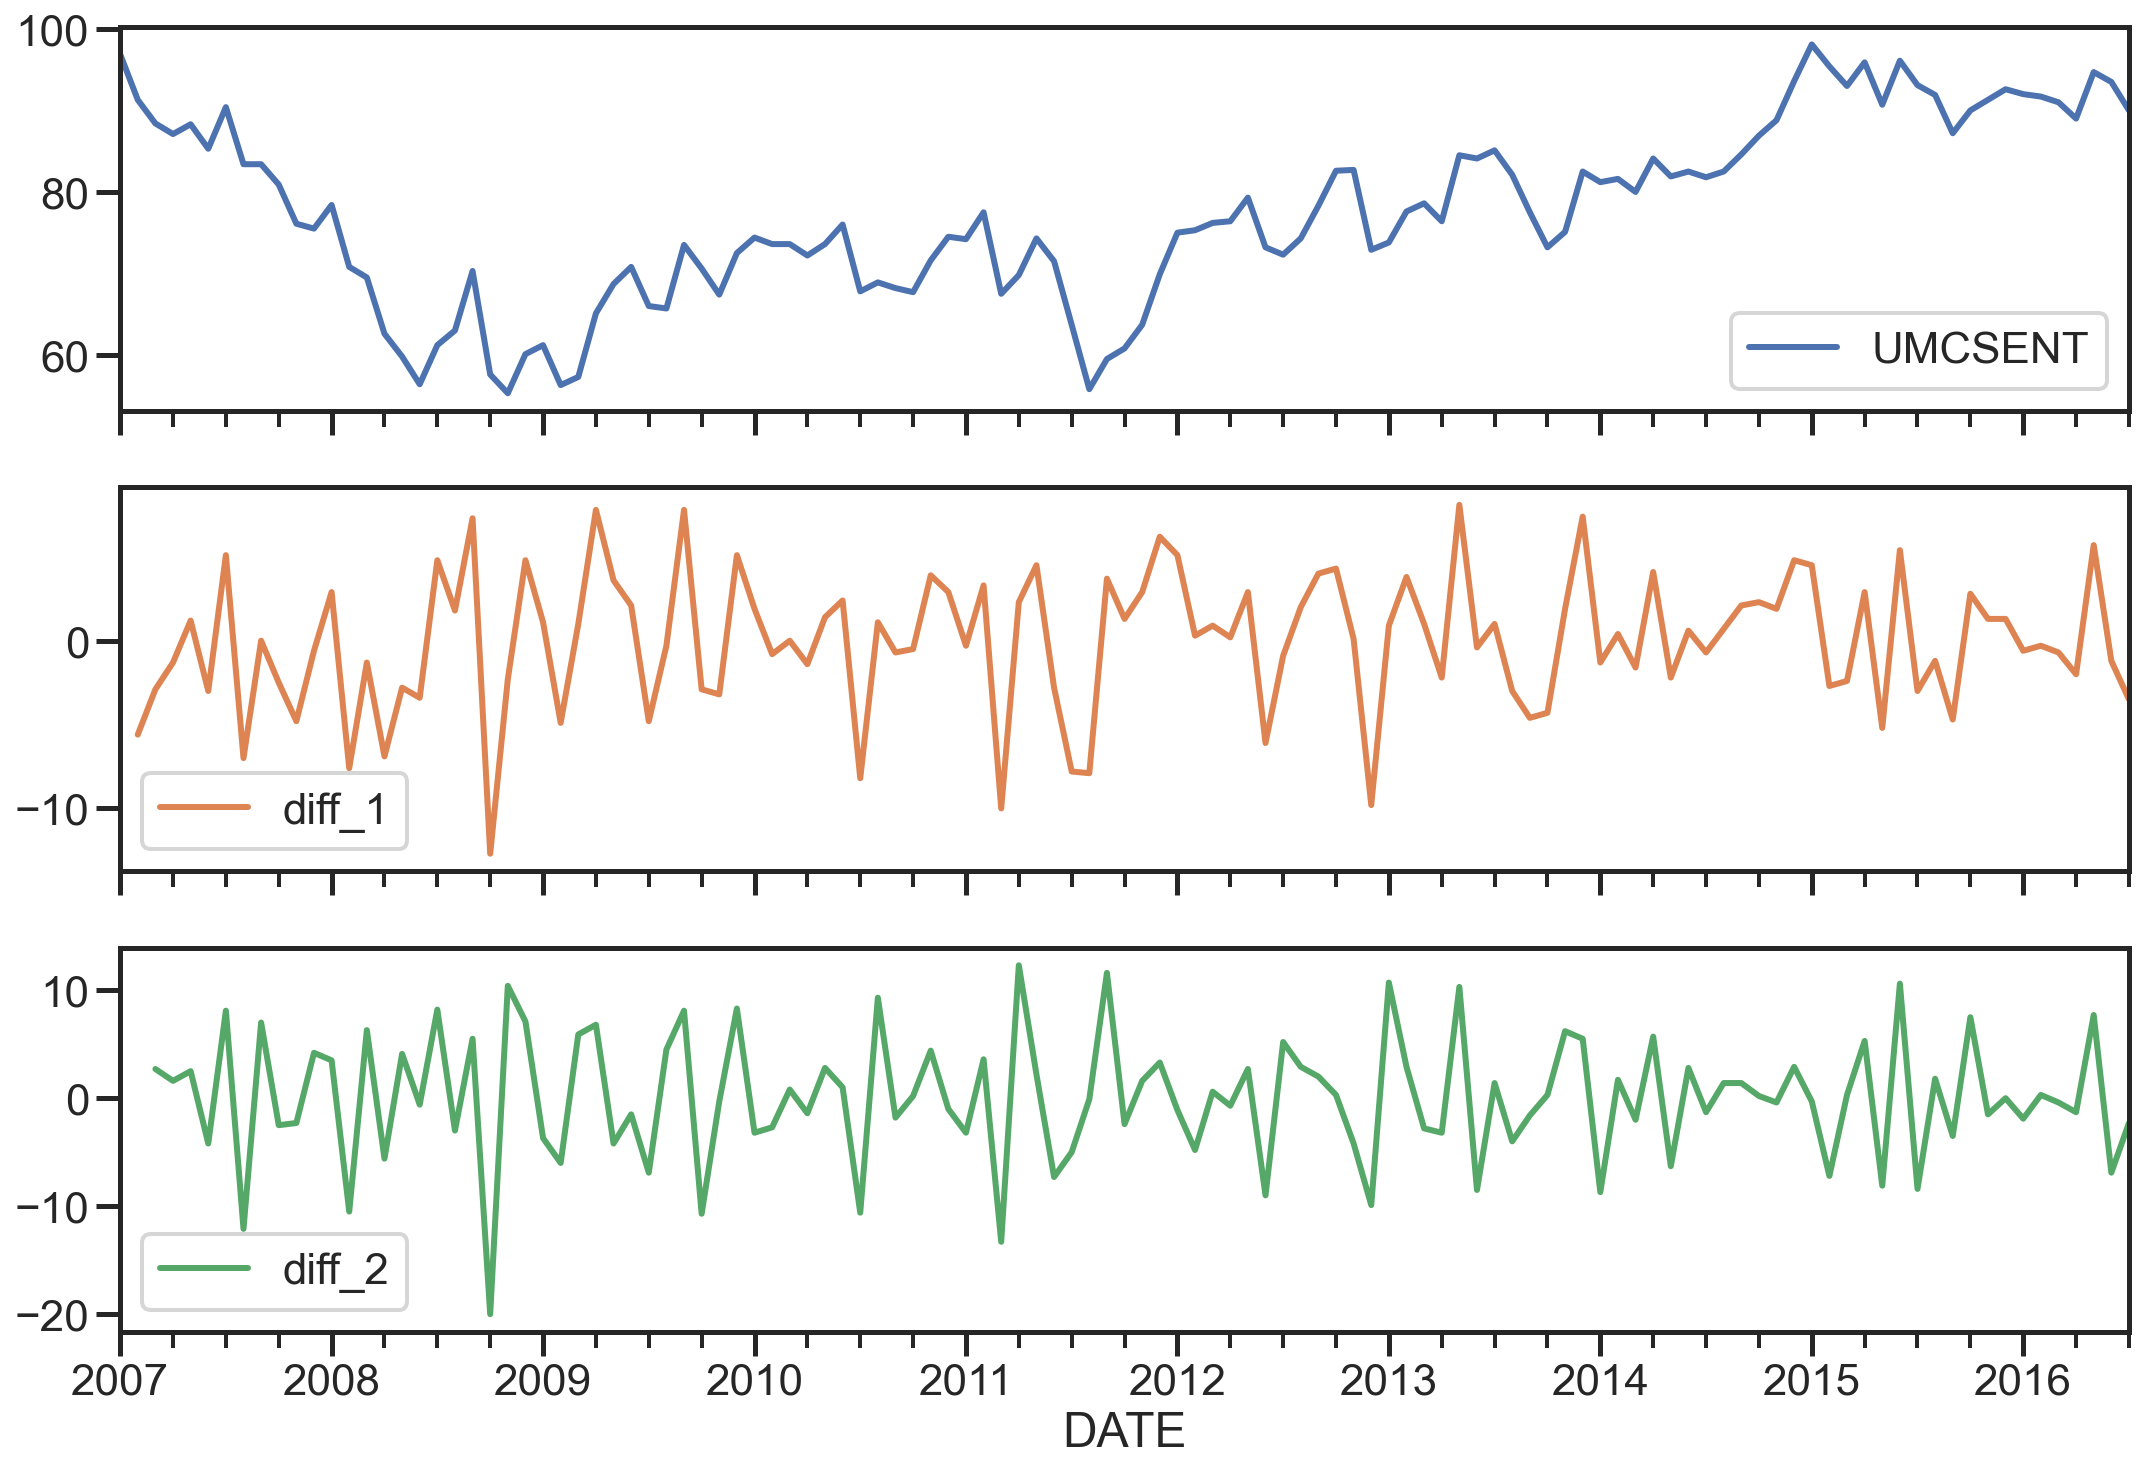

In [13]:
#一阶差分
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
#二阶差分
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
print(sentiment_short.head())
sentiment_short.plot(subplots=True, figsize=(18, 12))

            UMCSENT
DATE               
2007-01-01 96.90000
2007-02-01 91.30000
2007-03-01 88.40000
2007-04-01 87.10000
2007-05-01 88.30000
<class 'pandas.core.frame.DataFrame'>


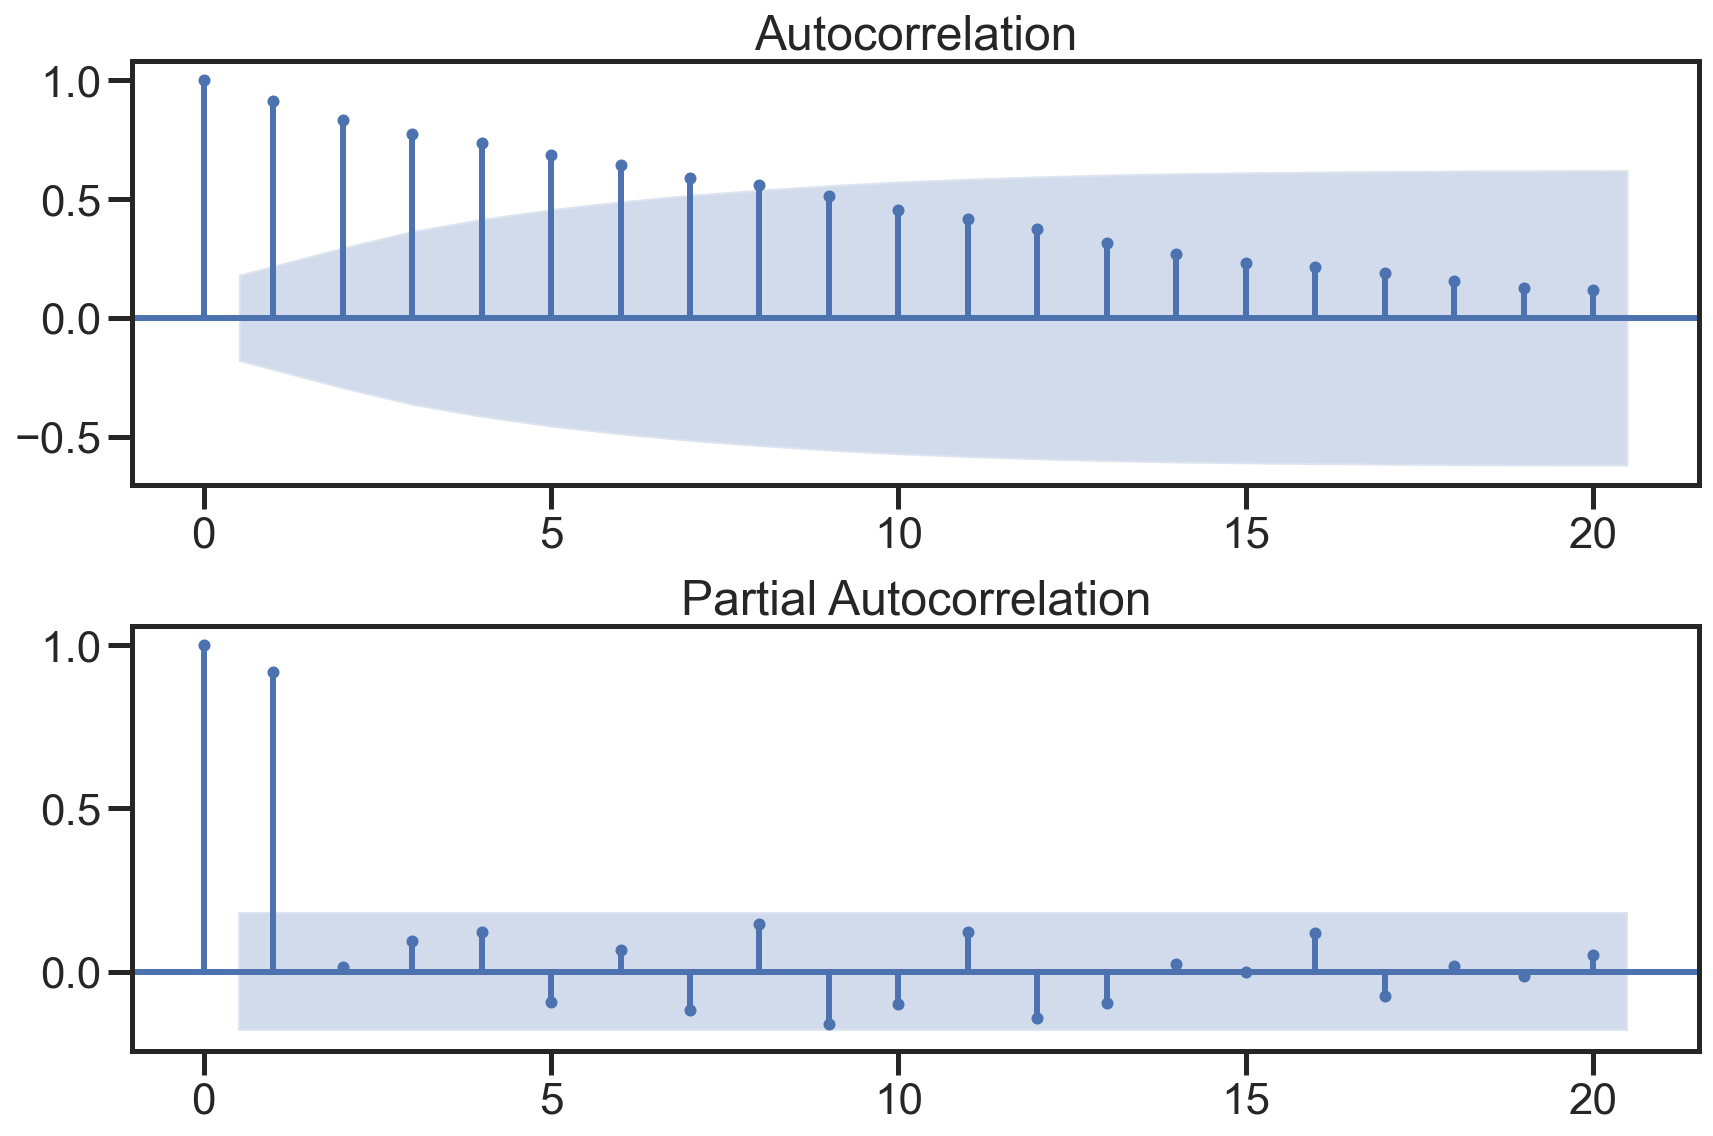

In [14]:
# 先删除差分数据，不然画图时候报错
del sentiment_short['diff_2']
del sentiment_short['diff_1']
print(sentiment_short.head())
print (type(sentiment_short))
fig = plt.figure(figsize=(12,8))
#画ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short, lags=20,ax=ax1)#lags表示滞后的阶数
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#画PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [15]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

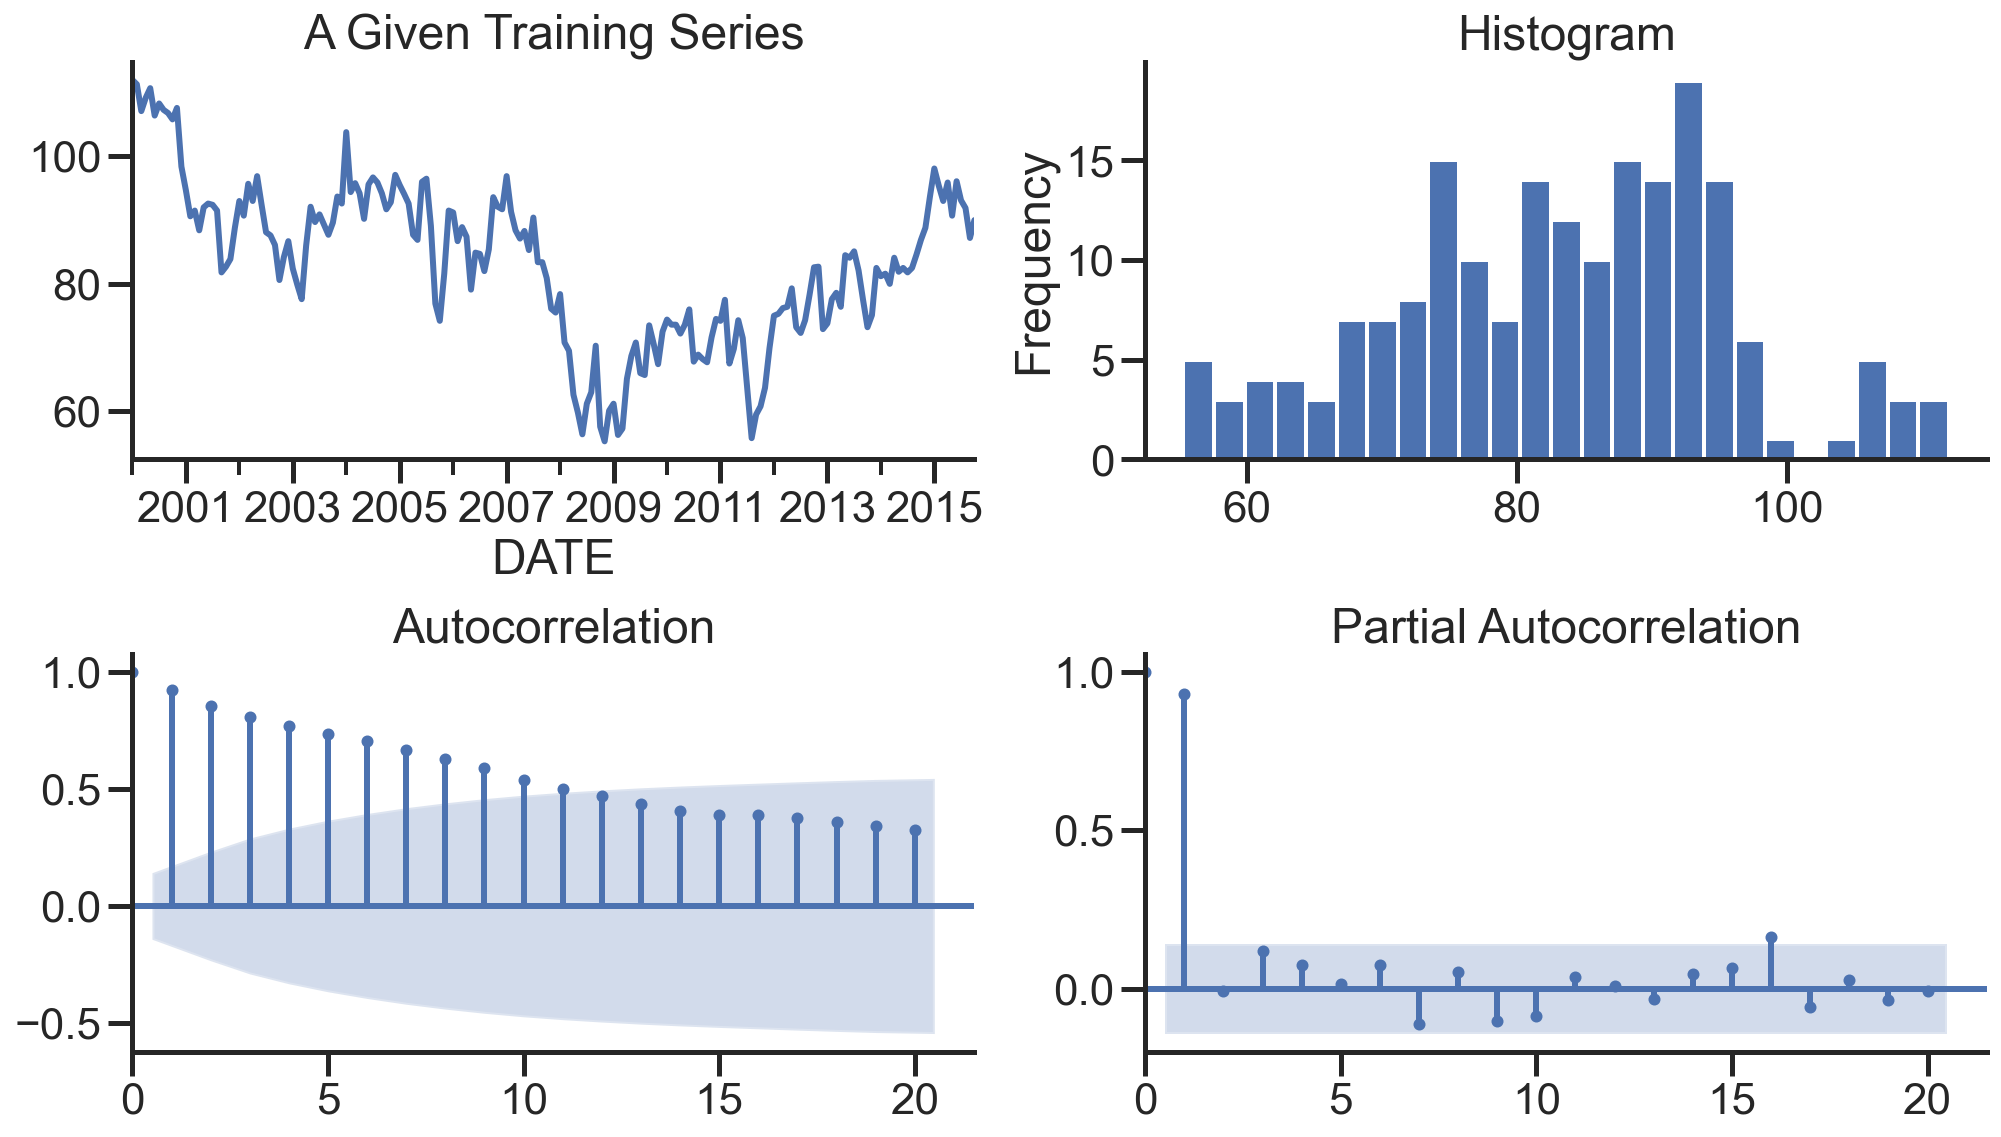

In [16]:
tsplot(ts_train, title='A Given Training Series', lags=20);

In [17]:
import warnings
warnings.filterwarnings("ignore")

arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()
#遍历，寻找适宜的参数
import itertools
 
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

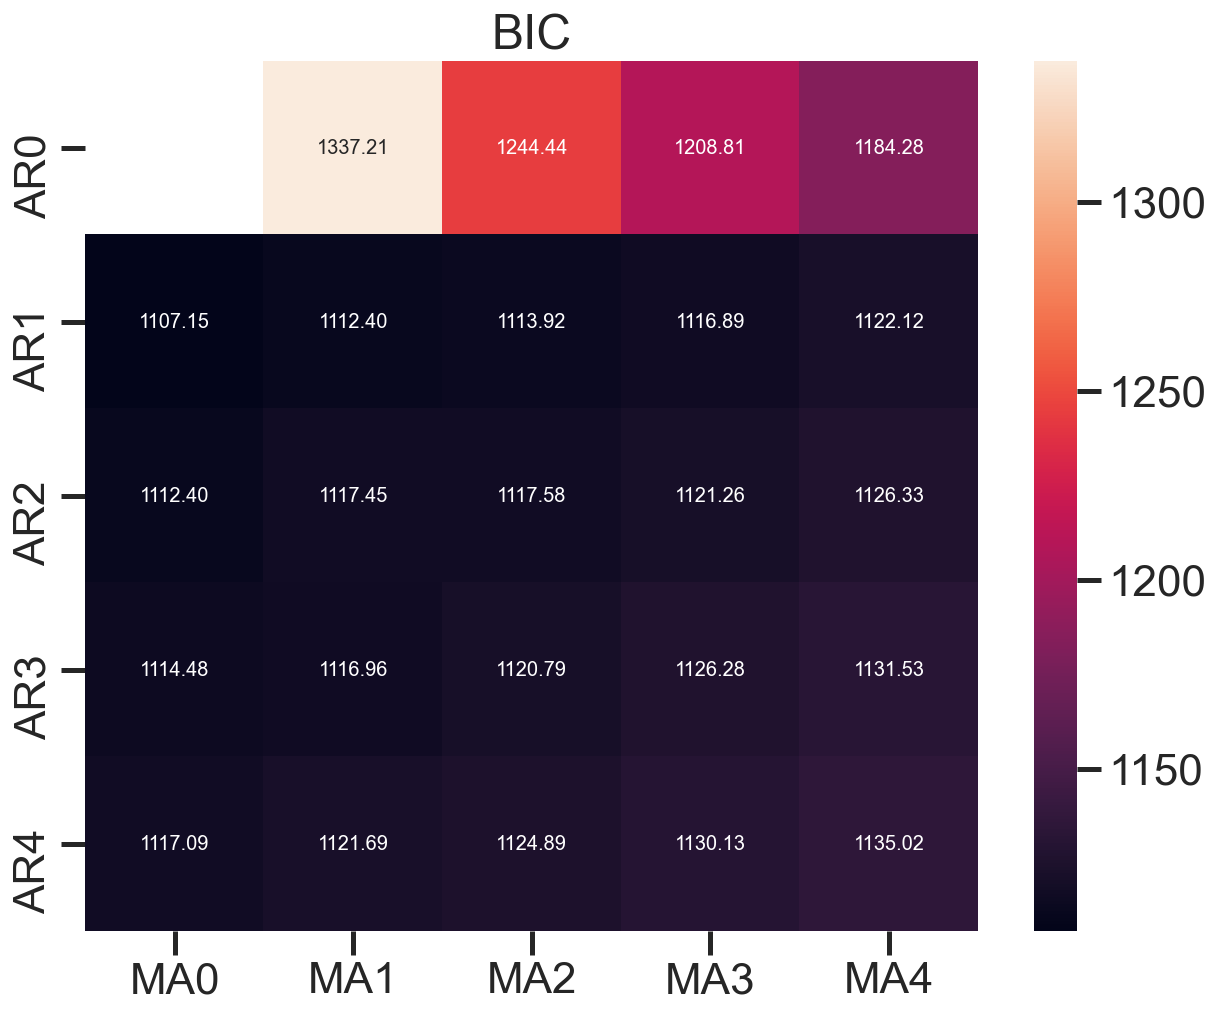

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')
plt.show()

In [19]:
# warnings.filterwarnings("ignore")
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 3)
BIC (1, 0)


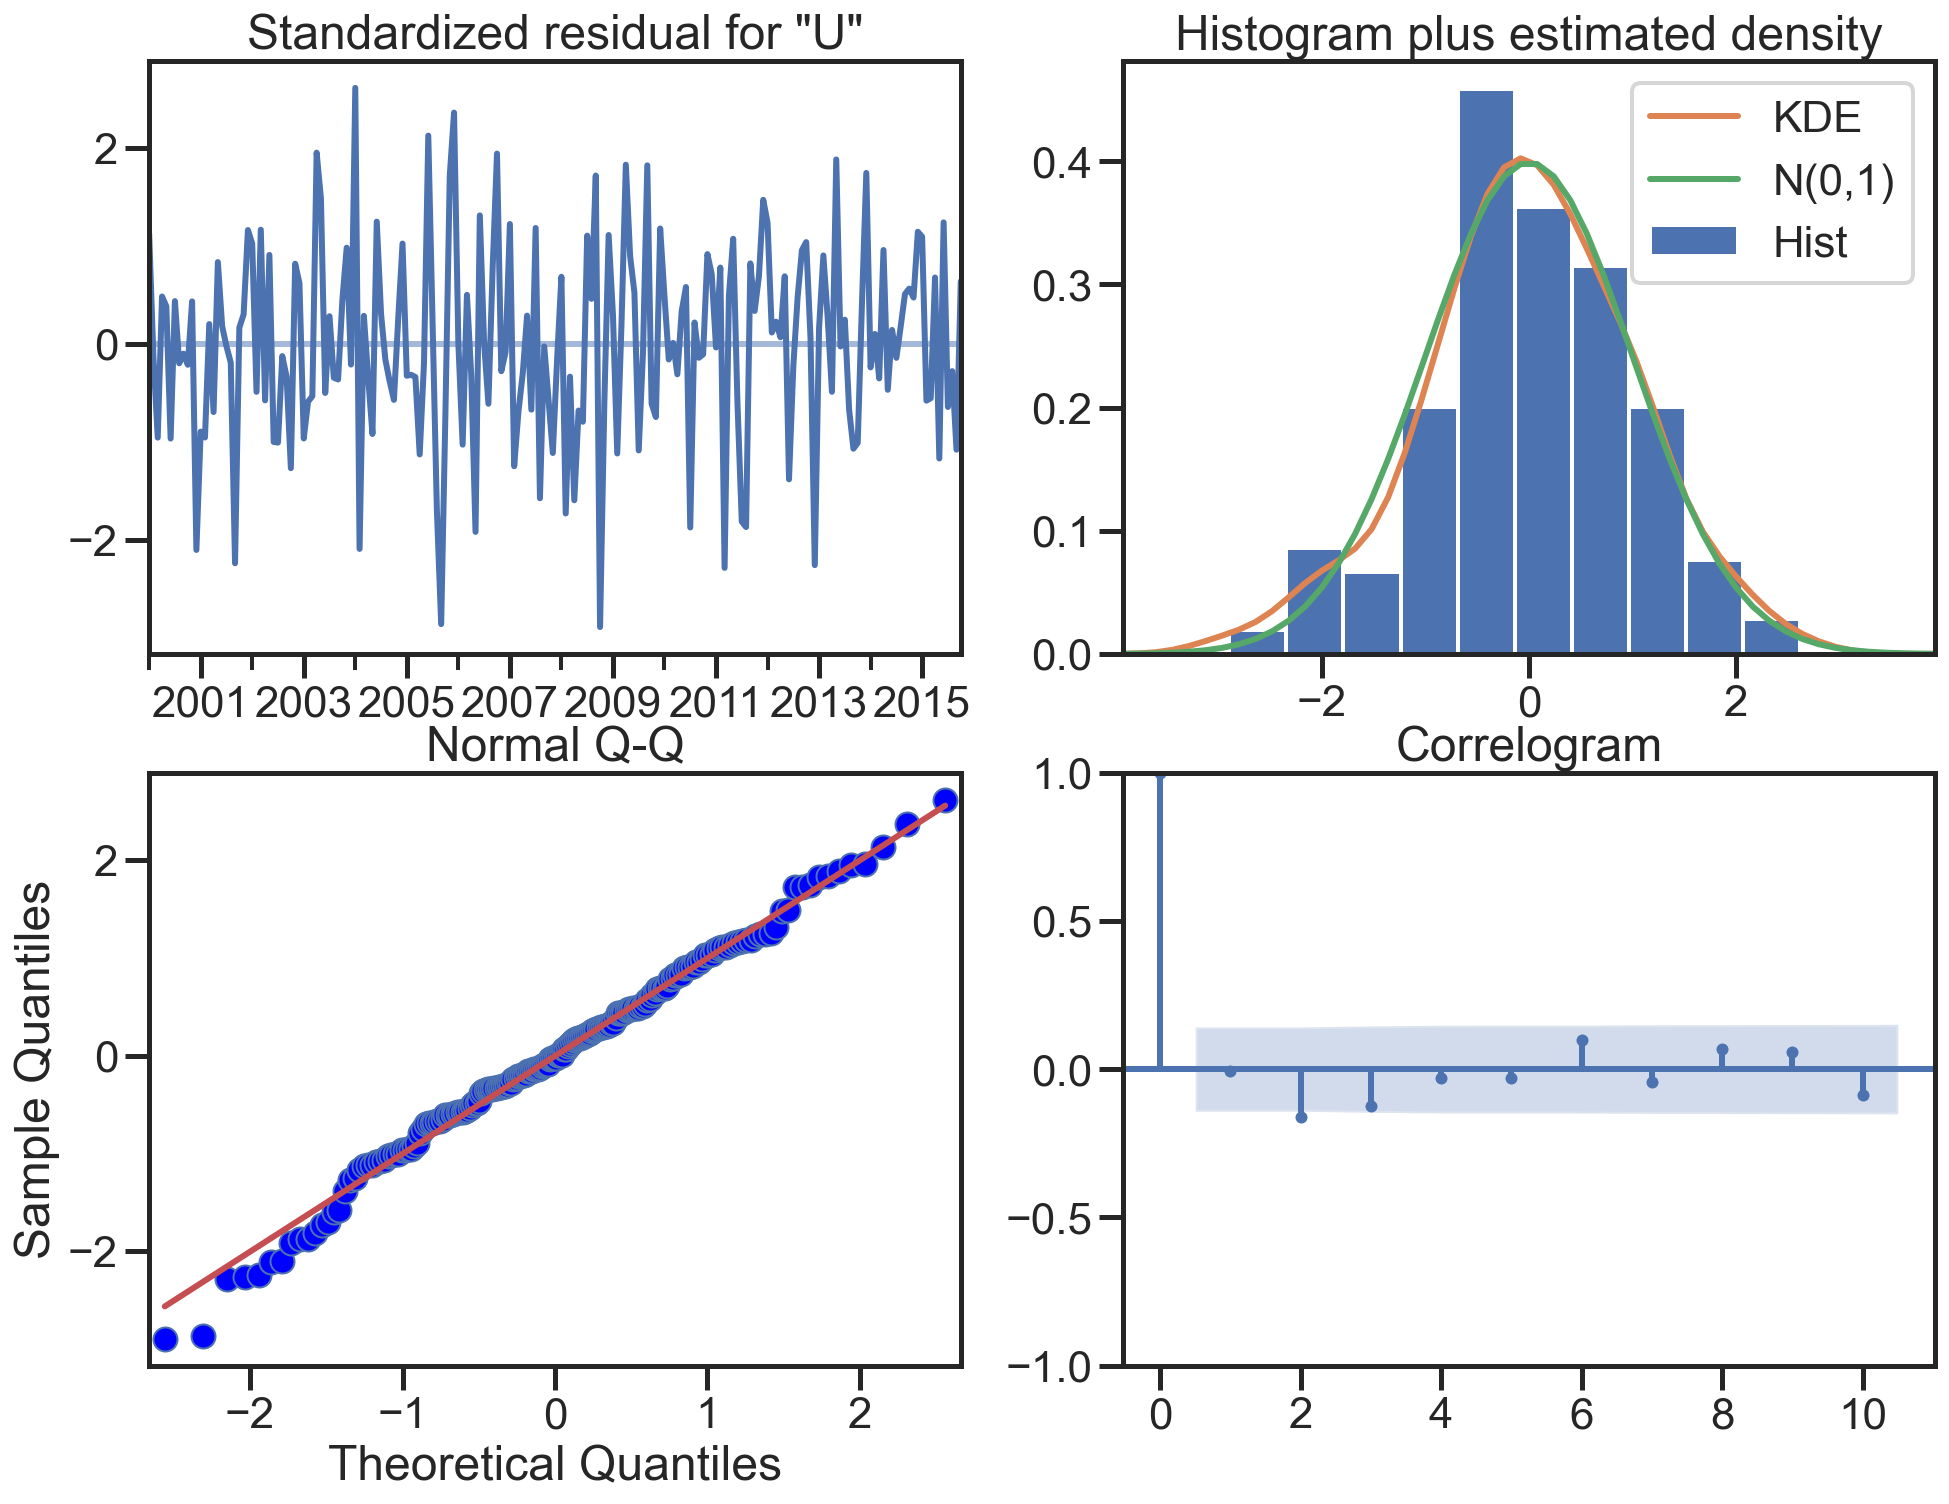

In [20]:
# 模型评估：残差分析 正态分布 QQ图线性
model_results.plot_diagnostics(figsize=(16, 12));